# WNBL Plotting

Demonstration of loading multiple csv files and plotting various features.  

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import wnbl

data_path = "..\\data"

In [2]:
def boxplot_sorted_by_position(df, by, column, position, rot=0):
    # use dict comprehension to create new dataframe from the iterable groupby object
    # each group name becomes a column in the new dataframe
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    # find and sort the median values in this new dataframe
    # meds = df2.median().sort_values()
    pos = position['Position'].sort_values(ascending=False)
    colnames = position.iloc[pos.index]['Team']
    # use the columns in the dataframe, ordered sorted by median value
    # return axes so changes can be made outside the function
    return df2[colnames].boxplot(rot=rot, return_type="axes", vert=False)

In [3]:
def boxplot_sorted_by_median(df, by, column, rot=0):
    # use dict comprehension to create new dataframe from the iterable groupby object
    # each group name becomes a column in the new dataframe
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    # find and sort the median values in this new dataframe
    meds = df2.median().sort_values()
    # use the columns in the dataframe, ordered sorted by median value
    # return axes so changes can be made outside the function
    return df2[meds.index].boxplot(rot=rot, return_type="axes", vert=False)

In [4]:
# concatenate all teams by season info, drop duplicates to define unique TeamID and name mapping
teams_df = wnbl.load_csv(data_path,'teams')
teams_df = teams_df.drop_duplicates().reset_index()
teams_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   25 non-null     int64 
 1   Team    25 non-null     object
 2   TeamID  25 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 728.0+ bytes


In [5]:
# concatenate all players by season stats
players_df = wnbl.load_csv(data_path,'players',include_id=True)

# fix html encoded apostrophes iin names
players_df['Player'] = players_df['Player'].str.replace("&#039;","'")
players_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3004 entries, 0 to 105
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  3004 non-null   object 
 1   G       3004 non-null   int64  
 2   PTS     3004 non-null   int64  
 3   FGA     3004 non-null   int64  
 4   FGM     3004 non-null   int64  
 5   FG%     3004 non-null   float64
 6   3PA     3004 non-null   int64  
 7   3PM     3004 non-null   int64  
 8   3P%     3004 non-null   float64
 9   FTA     3004 non-null   int64  
 10  FTM     3004 non-null   int64  
 11  FT%     3004 non-null   float64
 12  DEF     3004 non-null   int64  
 13  OFF     3004 non-null   int64  
 14  REB     3004 non-null   int64  
 15  AST     3004 non-null   int64  
 16  BLK     3004 non-null   int64  
 17  STL     3004 non-null   int64  
 18  TO      3004 non-null   int64  
 19  TeamID  3004 non-null   int64  
 20  CompID  3004 non-null   int32  
dtypes: float64(3), int32(1), int64(16), ob

In [6]:
# concatenate all standings by seasons
standings_df = wnbl.load_csv(data_path,'standings',include_id=True)

# remove logo column (NaN)
standings_df = standings_df.drop(standings_df.columns[1], axis=1)
standings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225 entries, 0 to 7
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Position  225 non-null    int64 
 1   Team      225 non-null    object
 2   W         225 non-null    int64 
 3   L         225 non-null    int64 
 4   %won      225 non-null    int64 
 5   L5        83 non-null     object
 6   For       225 non-null    int64 
 7   Agst      225 non-null    int64 
 8   HW        225 non-null    int64 
 9   HL        225 non-null    int64 
 10  AW        225 non-null    int64 
 11  AL        225 non-null    int64 
 12  TeamID    225 non-null    int64 
 13  CompID    225 non-null    int32 
dtypes: int32(1), int64(11), object(2)
memory usage: 25.5+ KB


In [7]:
# load seasons (maps year to competition)
# seasons_df = pd.read_csv(os.path.join(data_path,'seasons.csv'))
seasons_df = wnbl.load_csv(data_path,'seasons.csv')

# identify current seasons
comp_id = seasons_df['CompID'].max()

In [8]:
seasons_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Season  26 non-null     object
 1   Year    26 non-null     int64 
 2   URL     26 non-null     object
 3   CompID  26 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 960.0+ bytes


In [9]:
print(players_df.shape)
print(seasons_df.shape)
print(teams_df.shape)

(3004, 21)
(26, 4)
(25, 3)


In [10]:
# merge players and seasons so we can plot by date
players_df = players_df.merge(seasons_df,on='CompID',how='left')

In [11]:
players_df = players_df.merge(teams_df,on='TeamID',how='left')
# players_df = players_df.rename(columns={'Team_y':'Team'})

In [12]:
# associate team full name with standings
standings_df = standings_df.merge(teams_df,on='TeamID',how='left')
standings_df = standings_df.rename(columns={'Team_y':'Team'})

In [13]:
# New features
da = players_df

# efficiency
da['EFF'] = da['PTS'] + da['REB'] + da['AST'] + da['STL'] + da['BLK'] - (da['FGA'] - da['FGM']) - (da['3PA'] - da['3PM'])  - (da['FTA'] - da['FTM']) - da['TO']

# efficiency per game
da['EPG'] = da['EFF'] / da['G']

In [ ]:
# filter data by comp

tmp = da[da['CompID']==comp_id]
tmp = tmp[['Team','EPG']]
tmp.info()

In [ ]:
# identify outliers, filter by current comp

# team_q1 = tmp.groupby('Team').quantile(0.25)['EPG'].to_numpy()
# team_q3 = tmp.groupby('Team').quantile(0.75)['EPG'].to_numpy()
# outlier_top_lim = team_q3 + 1.5 * (team_q3 - team_q1)
# outlier_bottom_lim = team_q1 - 1.5 * (team_q3 - team_q1)

In [ ]:
# Plot - need position from standings

# filter standings by competition to match stats
dfs = standings_df[standings_df['CompID']==comp_id].reset_index()

ax = boxplot_sorted_by_position(tmp, by=['Team'], column="EPG",position=dfs)
ax.set(xlabel='EPG',ylabel='Team',title='WNBL 2020 Distribution of Player Efficiency Per Game\nOrdered by Standings Dec 1st 2020')

ax.figure.set_size_inches(10,5)
ax.figure.savefig('wnbl20_team_standings_boxplot.png',bbox_inches='tight')

In [ ]:
# Plot ordered by median EPG
ax = boxplot_sorted_by_median(tmp, by=['Team'], column="EPG")
ax.set(xlabel='EPG',ylabel='Team',title='WNBL 2020 Distribution of Player Efficiency Per Game\nOrdered by Decreasing Team EPG Median')

ax.figure.set_size_inches(10,5)
ax.figure.savefig('wnbl20_team_median_boxplot.png',bbox_inches='tight')

In [ ]:

# multiline plot
# tmp =da[['Player','Year','EPG']]
# fig, ax = plt.subplots(figsize=(8,6))
# for label, df in tmp.sort_values('Year').groupby('Player'):
#     df.plot(x='Year',y='EPG', ax=ax, label=label)
# plt.legend(loc='upper left')

In [ ]:
# identify top player per team in current season
tmp = da[['Player','Team','Year','EPG','CompID','TeamID']]
tmp = tmp[tmp['CompID']==comp_id]
top_players = tmp.sort_values(['TeamID', 'EPG'], axis=0).groupby('TeamID').tail(1)['Player']

# identify current team for these top players
current_teams = tmp[tmp['Player'].isin(top_players)][['Player','Team']]


In [ ]:
# filter top player data
tmp = da[['Player','Team','Year','EPG']]
tmp = tmp[tmp['Player'].isin(top_players)]
# tmp['Player-Team'] = tmp['Player'].str.cat(tmp['Team'],sep=" ")
tmp = tmp.merge(current_teams,on='Player')
tmp['Player-Team'] = tmp['Player'] + ' (' + tmp['Team_y'] + ') '


In [ ]:
# facet plot of top player historial EPG

tmp = da[['Player','Team','Year','EPG']]
tmp = tmp[tmp['Player'].isin(top_players)]
# tmp['Player-Team'] = tmp['Player'].str.cat(tmp['Team'],sep=" ")
tmp = tmp.merge(current_teams,on='Player')
tmp['Player-Team'] = tmp['Player'] + '\n(' + tmp['Team_y'] + ') '

# Create a grid : initialize it
g = sns.FacetGrid(tmp.sort_values('Year'), col='Player-Team', hue='Player-Team', col_wrap=4)
 
# Add the line over the area with the plot function
g = g.map(plt.plot, 'Year', 'EPG')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 'Year', 'EPG', alpha=0.2).set_titles("{col_name} Player-Team")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plot
plt.subplots_adjust(top=0.85)
sns.set(rc={'figure.figsize':(12,8)})
g = g.fig.suptitle('Historical Performance of Top WNBL Players Per Team in 2020')

plt.text(2020,-13,"linkedin.com/in/evassiliadis",ha='right',alpha=0.5)
plt.text(2020,-16,"github.com/vass1138/wnbl",ha='right',alpha=0.5)
plt.savefig('wnbl_top_players_history.png')
plt.show()

In [38]:
# similar facet plot but focus on all players in given team
tmp = da[['Player','Team','Year','EPG','CompID']]


In [41]:
tmp = tmp[tmp['CompID']==comp_id]
team_players = tmp[tmp['Team']=='Southside Flyers']
team_players = team_players.sort_values(by=['Player']).reset_index()['Player']

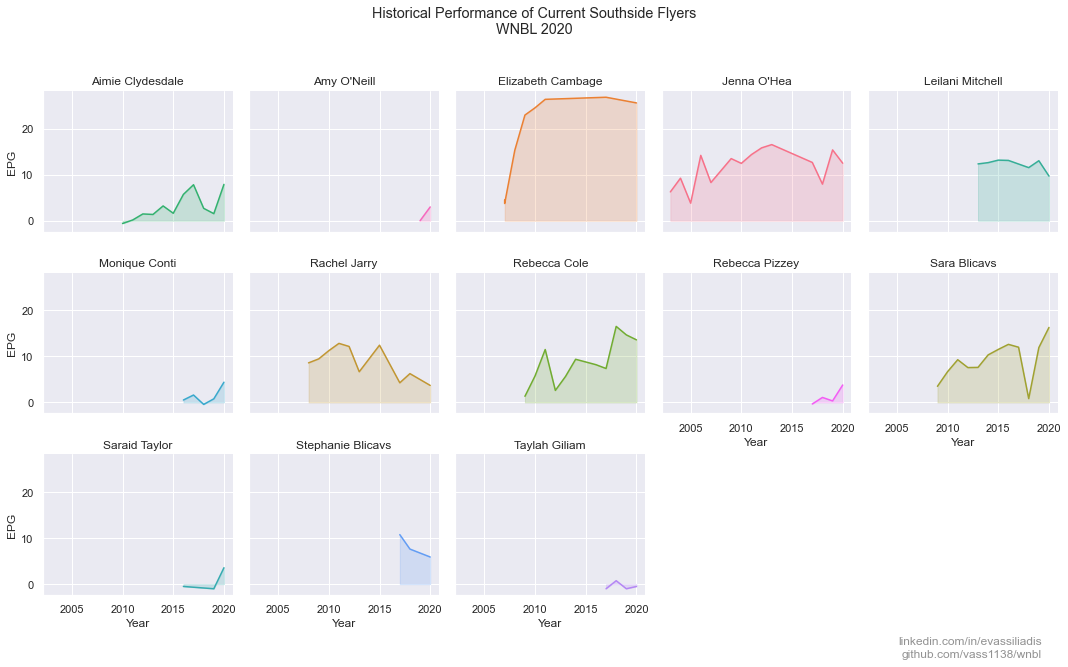

In [43]:
tmp = da[['Player','Team','Year','EPG']]
tmp = tmp[tmp['Player'].isin(team_players)]


# Create a grid : initialize it
g = sns.FacetGrid(tmp.sort_values('Year'), col='Player', col_order=team_players, hue='Player', col_wrap=5)
 
# Add the line over the area with the plot function
g = g.map(plt.plot, 'Year', 'EPG')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 'Year', 'EPG', alpha=0.2).set_titles("{col_name} Player")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plot
plt.subplots_adjust(top=0.85)
sns.set(rc={'figure.figsize':(12,8)})
g = g.fig.suptitle('Historical Performance of Current Southside Flyers\nWNBL 2020')

plt.text(2060,-13,"linkedin.com/in/evassiliadis",ha='right',alpha=0.5)
plt.text(2060,-16,"github.com/vass1138/wnbl",ha='right',alpha=0.5)
plt.savefig('wnbl_flyers_history_20.png')
plt.show()